In [170]:
from lsst.source.injection import generate_injection_catalog
from lsst.source.injection import ingest_injection_catalog
from lsst.daf.butler import Butler
import numpy as np
import os
from astropy.table import QTable, Table, Column
from matplotlib import pyplot as plt

In [171]:
RUN_NUMBER = "01"

In [172]:
n_inject = 20
source_type="Trail"
trail_length=[4, 74]
mag=[20.1, 27.2]
beta=[0, 90]

In [173]:
user = os.getenv("USER")
REPO = "/epyc/ssd/users/kmrakovc/DATA/rc2_subset/SMALL_HSC/"
INPUT_COLL = "u/kmrakovc/RC2_subset/run_1"
OUTPUT_COLL = "u/"+user+"/single_frame_injection_"+RUN_NUMBER
# Instantiate a butler.
butler = Butler(REPO)

In [174]:
registry = butler.registry
ra = []
dec = []
last_id=0
injection_catalog = Table(names=('injection_id', 'ra', 'dec', 'source_type', 'trail_length', 'mag', 'beta', 'visit'), 
                          dtype=('int64', 'float64', 'float64', 'str', 'int64', 'float64', 'float64', 'int64'))
length = len(list(registry.queryDatasets("calexp", collections=INPUT_COLL, instrument='HSC')))
for i,ref in enumerate(registry.queryDatasets("calexp", collections=INPUT_COLL, instrument='HSC')):
    raw = butler.get(
        "calexp",
        dataId=ref.dataId,
        collections=INPUT_COLL,
    )
    start = raw.wcs.pixelToSky(0,0)
    end = raw.wcs.pixelToSky(raw.getDimensions()[0],raw.getDimensions()[1])
    
    min_ra = start.getRa()
    min_dec = start.getDec()
    max_ra = end.getRa()
    max_dec = end.getDec()
    if not ([min_ra, max_ra] in ra) and not ([min_dec, max_dec] in dec):
        ra.append([min_ra, max_ra])
        dec.append([min_dec, max_dec])
        for k in range(last_id, last_id+n_inject):
            ra_pos = np.random.uniform (low=min_ra.asDegrees(), high=max_ra.asDegrees())
            dec_pos = np.random.uniform (low=min_dec.asDegrees(), high=max_dec.asDegrees())
            inject_length = np.random.uniform (low=trail_length[0], high=trail_length[1])
            magnitude = np.random.uniform (low=mag[0], high=mag[1])
            angle = np.random.uniform (low=beta[0], high=beta[1])
            visitid = raw.getInfo().getVisitInfo().id
            injection_catalog.add_row([k, ra_pos, dec_pos, "Trail", inject_length, magnitude, angle, visitid])
        last_id=k
    print("\r",i+1, "/", length, end="")
injection_catalog

 240 / 240

injection_id,ra,dec,source_type,trail_length,mag,beta,visit
int64,float64,float64,str5,int64,float64,float64,int64
0,150.16415112917346,2.162934084822738,Trail,29,20.649543191946826,78.26690252664388,322
1,150.10521921021888,2.1035635044951775,Trail,64,23.078481364603757,28.99307808599235,322
2,150.20502801893258,2.097554662719124,Trail,4,20.105214959248617,10.64103684601065,322
3,150.10700199605608,2.099768101548243,Trail,73,22.6271017999047,72.26471561794175,322
4,150.12067271556842,2.178978645706746,Trail,18,23.206310986772984,0.1697209956593837,322
5,150.1363463340661,2.1522455194242336,Trail,33,21.208136877636726,67.33603307598919,322
6,150.23499677625034,2.1537483007394522,Trail,41,22.074168832791937,37.94408455235992,322
7,150.14118312716388,2.1223525905792395,Trail,47,21.7010328546702,32.212964706810425,322
8,150.14522293462227,2.162300900456344,Trail,59,24.356608473641632,77.51996317641833,322


In [175]:
# Instantiate a writeable Butler.
writeable_butler = Butler(REPO, writeable=True)

# Ingest the injection catalog.
for bands in ["g","r","i","z","y"]:
    my_injected_datasetRefs = ingest_injection_catalog(
        writeable_butler=writeable_butler,
        table=injection_catalog,
        band=bands,
        output_collection=f"u/{user}/injection_inputs_"+RUN_NUMBER)

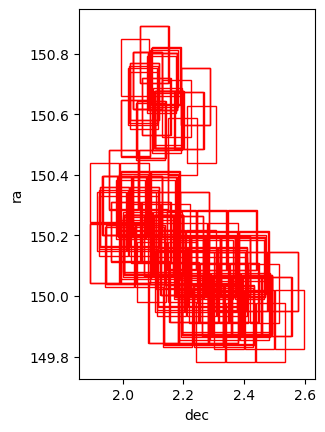

In [135]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

max_dec = np.max(dec).asDegrees()
min_dec = np.min(dec).asDegrees()
max_ra = np.max(ra).asDegrees()
min_ra = np.min(ra).asDegrees()

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.plot(max_dec,max_ra)
# Create a Rectangle patch
for i in range(len(ra)):
    rect = patches.Rectangle((dec[i][1].asDegrees(), ra[i][0].asDegrees()), -dec[i][0].asDegrees()+dec[i][1].asDegrees(), -ra[i][0].asDegrees()+ra[i][1].asDegrees(), linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
ax.set_xlabel("dec")
ax.set_ylabel("ra")
ax.set_aspect('equal', adjustable='box')
plt.show()